<b>The code below used STLM by using only Capacity field to predict the RUL(STLM using one variable with multisteps)</b> 
<p>We built the model only on Battery B0005</p>

In [1]:
import sys 
import numpy as np # linear algebra
from scipy.stats import randint
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib.pyplot as plt # this is used for the plot the graph 
import seaborn as sns # used for plot interactive graph. 
from sklearn.model_selection import train_test_split # to split the data into two parts
#from sklearn.cross_validation import KFold # use for cross validation
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score
from keras.callbacks import History 
## for Deep-learing:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout

Using TensorFlow backend.


In [219]:
df=pd.read_csv("B0005_discharge.csv")
#featurs=['Batt_name','cycle','amb_temp','voltage_battery','current_battery','temp_battery','current_load','voltage_load','time','Capacity','NewCap']
f1=['cycle','Capacity']
df=df[f1]
#dataset=df[(df.Batt_name =='B0005')| (df.Batt_name =='B0006') | (df.Batt_name =='B0007')|(df.Batt_name =='B0018')]
# Feature Selection
#dataset=df[(df['Batt_name']=='B0006_11')]
dataset=df#<70 need window to be 10
#dataset=dataset[f1]
train_num=61
data_train=dataset[(dataset['cycle']<train_num)]
data_set_train=data_train.iloc[:,1:2].values
data_test=dataset[(dataset['cycle']>=train_num)]
data_set_test=data_test.iloc[:,1:2].values
#Windoow Size after 90 could be 30 is a goood choise
from sklearn.preprocessing import MinMaxScaler
sc=MinMaxScaler(feature_range=(0,1))
data_set_train=sc.fit_transform(data_set_train)
data_set_test=sc.transform(data_set_test)

X_train=[]
y_train=[]
window_size=5 #int(train_num/2)
#cycle 82 ===> Wz:40==>pred: 78
#take the last 10t to predict 10t+1
#Cycle 110 ===> WZ:40 ===> batchz:32
for i in range(window_size,train_num-1):
    X_train.append(data_set_train[i-window_size:i,0])
    y_train.append(data_set_train[i,0])
X_train,y_train=np.array(X_train),np.array(y_train)
 
X_train=np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))


In [220]:
ln=len(data_train)
ln
print(len(X_train))

55


<h1> Applied STLM </h1>

In [ ]:
regress=Sequential()
from keras import regularizers
regress.add(LSTM(units=200, return_sequences=True, input_shape=(X_train.shape[1],1)))
regress.add(Dropout(0.3))

regress.add(LSTM(units=200, return_sequences=True))
regress.add(Dropout(0.3))


regress.add(LSTM(units=200, return_sequences=True))
regress.add(Dropout(0.3))

regress.add(LSTM(units=200))
regress.add(Dropout(0.3))


regress.add(Dense(units=1))

regress.compile(optimizer='adam',loss='mean_squared_error',metrics=['mse'])

hist=regress.fit(X_train,y_train,epochs=100,batch_size=30)


In [29]:
#function to calculate the sum of the difference between two cycles.
def diff_avg(Data_set):
    data_sum=Data_set.iloc[:,1:2]
    avg=0
    init=data_sum['Capacity'][0]
    substr=0.0
    calcul=0.0
    for i in range(1,len(data_sum)):
        substr=init-data_sum['Capacity'][i]
        calcul=calcul+ substr
        init=data_sum['Capacity'][i]
    avg=calcul/len(data_sum)
    return (avg)
   


In [34]:
#sc=MinMaxScaler(feature_range=(0,1))
def Scale_X(dataset,lag):#return the 3 D array for training and 1 D to actual value.
   # from sklearn.preprocessing import MinMaxScaler
    data=dataset.iloc[:,1:2].values
    data=sc.fit_transform(data)
    X_train=[]
    y_train=[]
    window_size=lag
    train_num=len(data)
    for i in range(window_size,train_num-1):
        X_train.append(data[i-window_size:i,0])
        y_train.append(data[i,0])
    X_train,y_train=np.array(X_train),np.array(y_train)
    X_train=np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
    return X_train, y_train

<h1> Test the Model that was built by STLM</h1>

In [200]:
len(data_test)
num_cycle_pred=5
cycles=len(data_train)+num_cycle_pred
print(cycles)
regress.loss
training_loss = hist.history['loss']
xx=0
for i in range(len(training_loss)):
    xx=xx+training_loss[i]
avg=xx/len(training_loss)
print(avg)
loss_train=training_loss[len(training_loss)-1]
ini_val=loss_train
print(loss_train)

55
0.039376487856109935
0.02568414869407813


In [201]:
#### predictions
#data_total=pd.concat((data_train['NewCap'],data_test['NewCap']),axis=0)
#inputs=data_total[len(data_total)-len(data_test)-10:].values
#inputs=inputs.reshape(-1,1)


In [ ]:
#### predictions, firstly we predict the next 5 cycles, then we add these cycles to the training dataset
### After that, we retrain the model with t+1,t+2,t3,t4,t5. and we do again to predict the t6 -t10 and so on.
k=0
while k<20:
    
    data_total=data_train['Capacity']
    avg=diff_avg(data_train)
    test=[]
    l=[]
    test=data_total[len(data_total)-window_size:]
    #print(test)
    #Make prediction to the next 5 cycles
    for i in range(num_cycle_pred):
        inputs1=test[len(test)-window_size-i:]
        if i <= 5:
            just_test=inputs1[i:window_size+i]
            print(just_test)
        inputs=test[len(test)-window_size-i:].values
        inputs=inputs.reshape(-1,1)
        inputs=sc.transform(inputs)
        X_test=[]    
        X_test.append(inputs[i:window_size+i,0])
        X_test=np.array(X_test)
        X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
        pred=regress.predict(X_test)
        pred=sc.inverse_transform(pred)
        pred=pred[:,0]
        print(pred)
        if loss_train>= 0.0199:#this filter used only when the error 0.02 or above,(by assumption)
            xx=float(pred)-avg
        else:
            xx=float(pred)#-avg
        ###########End of prediction###################
        ################################################
        #if loss_train>= 0.017:
         #   xx=float(pred)-avg#loss_train
        #elif ini_val>=1.07 and loss_train<0.017:
         #   xx=float(pred)+loss_train  
        #else:
         #   xx=float(pred)
        l.append(float(xx))
        y=test.index[len(test)-1]
        s1 = pd.Series(float(xx),index=[y+1])# convert the new prodiction to time series platform
        test=pd.concat([test,s1])
        j=len(data_train)+1
        s2=pd.Series([int(j),float(xx)],index=['cycle','Capacity'])# add new prediction to the Training dataset
        data_train=data_train.append(s2,ignore_index=True)
    X_train,y_train=Scale_X(data_train,window_size)# Scaling the training dataset with new cycles.
    hist=regress.fit(X_train,y_train,epochs=100,batch_size=30)# rebuild the model 
    training_loss = hist.history['loss']
    avg=diff_avg(data_train)# find avg(for thesum of the difference between two cycles)
    loss_train=training_loss[len(training_loss)-1]# get the RMSE
    k=k+1


In [ ]:
test

In [ ]:
print(data_train.head(90))
check=data_train
#
#print(X_train)
#for i in range(10,129):
  #  X_test.append(inputs[i-10:i,0])
#


In [ ]:
len(test)
data=data_train[(data_train['cycle'])]
data['pre']=l
data['diff']=data['Capacity']-data['pre']
print(data.head(60))
tests=data['Capacity']

In [213]:
data_train=check
len(data_train)

150

In [214]:

#print(float(pred))
#tests=data_test.iloc[:,1:2]
data_train=data_train[(data_train['cycle']>=50)&((data_train['cycle']<=150))]
dataset=dataset[(dataset['cycle']>=50)&((dataset['cycle']<=150))]

#rmse = np.sqrt(mean_squared_error(data_train['Capacity'], dataset['Capacity']))
#print('Test RMSE: %.3f' % rmse)
#metrics.r2_score(data_train['Capacity'],dataset['Capacity'])

Text(0.5, 1.0, 'Discharge B0005 (prediction)start in cycle 50 -RULe=NANE, window-size=5')

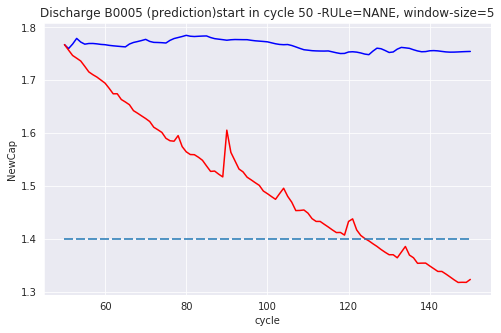

In [217]:

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plot_df = data_train.loc[(data_train['cycle']>=1),['cycle','Capacity']]
plot_per=dataset.loc[(dataset['cycle']>=1),['cycle','Capacity']]
sns.set_style("darkgrid")
plt.figure(figsize=(8, 5))
plt.plot(plot_df['cycle'], plot_df['Capacity'], label="Actual data", color='blue')
plt.plot(plot_per['cycle'],plot_per['Capacity'],label="Prediction data", color='red')
#plt.plot(pred)
#Draw threshold
plt.plot([50.0,150], [1.4, 1.4],dashes=[6, 2])
plt.ylabel('NewCap')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.title('Discharge B0005 (prediction)start in cycle 50 -RULe=NANE, window-size=5')

In [ ]:
actual=0
pred=0
Afil=0
Pfil=0
a=data_test['Capacity'].values
b=data_test['pre'].values
j=0
k=0
for i in range(len(a)):
    actual=a[i]
    
    if actual<=1.4:
        j=i
        Afil=j
        break
for i in range(len(a)):
    pred=b[i]
    if pred< 1.4:
        k=i
        Pfil=k
        break
print("The Actual fail at cycle number: "+ str(Afil+ln))
print("The prediction fail at cycle number: "+ str(Pfil+ln))
    
        

In [298]:
RULerror=Pfil-Afil
print("The error of RUL= "+ str(RULerror)+ " Cycle(s)")

The error of RUL= 0 Cycle(s)


<!--<h4> The LSTM model with(one input layer, 3 hidden layer and 1 output layer, and each layer with 200 neurons) the 
    results below show the prediction in different number of cycles.</h4>
 <h4> when the training dataset less than 70 cycles, we need to adjust the window(lage) to 10 rather than 5.</h4> -->

<!--<tabel>
    <tr>
        <td><img src="Cycle110-w5.png"></td>
        <td><img src="Cycle100-w5.png"></td>
  </tr>
     <tr>
        <td><img src="Cycle80-w5.png"></td>
  </tr>
</tabel>-->

Text(0.5, 1.0, 'Discharge B0005 (prediction)start in cycle 100 -RULe=+5, window-size=5')

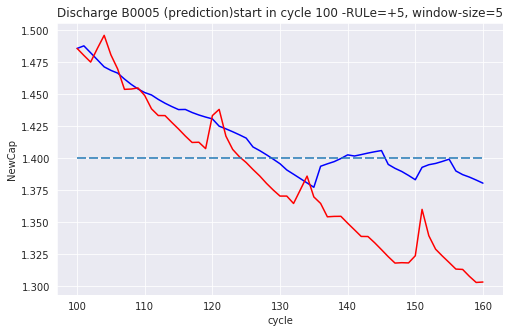

In [103]:

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plot_df = data_train.loc[(data_train['cycle']>=100),['cycle','Capacity']]
plot_per=dataset.loc[(dataset['cycle']>=100),['cycle','Capacity']]
sns.set_style("darkgrid")
plt.figure(figsize=(8, 5))
plt.plot(plot_df['cycle'], plot_df['Capacity'], label="Prediction data", color='blue')
plt.plot(plot_per['cycle'],plot_per['Capacity'],label="Actual data", color='red')
#plt.plot(pred)
#Draw threshold
plt.plot([100,160], [1.4, 1.4],dashes=[6, 2])
plt.ylabel('NewCap')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.title('Discharge B0005 (prediction)start in cycle 100 -RULe=+5, window-size=5')

Text(0.5, 1.0, 'Discharge B0005 (prediction)start in cycle 110 -RULe=+3, window-size=5')

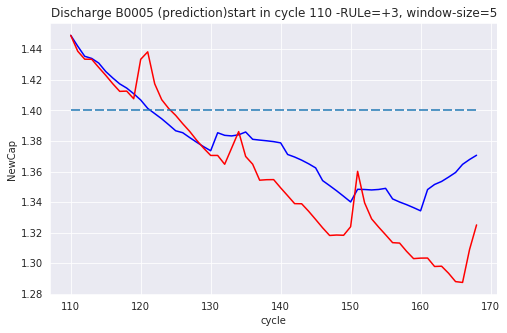

In [115]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plot_df = data_train.loc[(data_train['cycle']>=110),['cycle','Capacity']]
plot_per=dataset.loc[(dataset['cycle']>=110),['cycle','Capacity']]
sns.set_style("darkgrid")
plt.figure(figsize=(8, 5))
plt.plot(plot_df['cycle'], plot_df['Capacity'], label="Prediction data", color='blue')
plt.plot(plot_per['cycle'],plot_per['Capacity'],label="Actual data", color='red')
#plt.plot(pred)
#Draw threshold
plt.plot([110,168], [1.4, 1.4],dashes=[6, 2])
plt.ylabel('NewCap')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.title('Discharge B0005 (prediction)start in cycle 110 -RULe=+3, window-size=5')

Text(0.5, 1.0, 'Discharge B0005 (prediction)start in cycle 90 -RULe=-16, window-size=5')

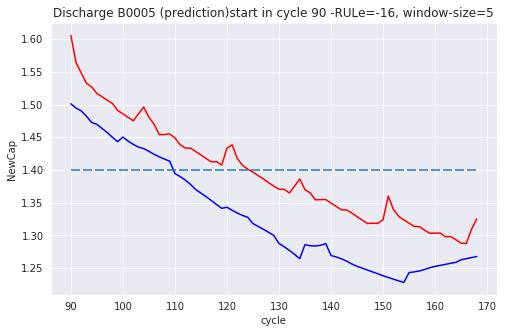

In [138]:

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plot_df = data_train.loc[(data_train['cycle']>=1),['cycle','Capacity']]
plot_per=dataset.loc[(dataset['cycle']>=1),['cycle','Capacity']]
sns.set_style("darkgrid")
plt.figure(figsize=(8, 5))
plt.plot(plot_df['cycle'], plot_df['Capacity'], label="Prediction data", color='blue')
plt.plot(plot_per['cycle'],plot_per['Capacity'],label="Actual data", color='red')
#plt.plot(pred)
#Draw threshold
plt.plot([90.0,168], [1.4, 1.4],dashes=[6, 2])
plt.ylabel('NewCap')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.title('Discharge B0005 (prediction)start in cycle 90 -RULe=-16, window-size=5')

Text(0.5, 1.0, 'Discharge B0005 (prediction)start in cycle 80 -RULe=-29, window-size=5')

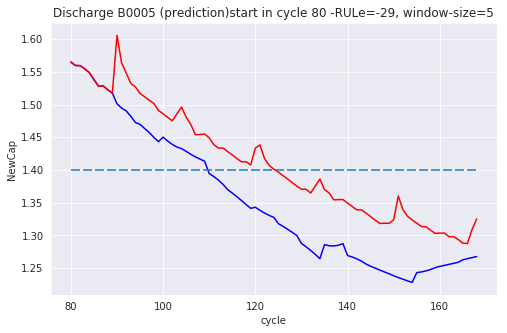

In [148]:

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plot_df = data_train.loc[(data_train['cycle']>=1),['cycle','Capacity']]
plot_per=dataset.loc[(dataset['cycle']>=1),['cycle','Capacity']]
sns.set_style("darkgrid")
plt.figure(figsize=(8, 5))
plt.plot(plot_df['cycle'], plot_df['Capacity'], label="Prediction data", color='blue')
plt.plot(plot_per['cycle'],plot_per['Capacity'],label="Actual data", color='red')
#plt.plot(pred)
#Draw threshold
plt.plot([80.0,168], [1.4, 1.4],dashes=[6, 2])
plt.ylabel('NewCap')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.title('Discharge B0005 (prediction)start in cycle 80 -RULe=-29, window-size=5')

Text(0.5, 1.0, 'Discharge B0005 (prediction)start in cycle 70 -RULe=-44, window-size=5')

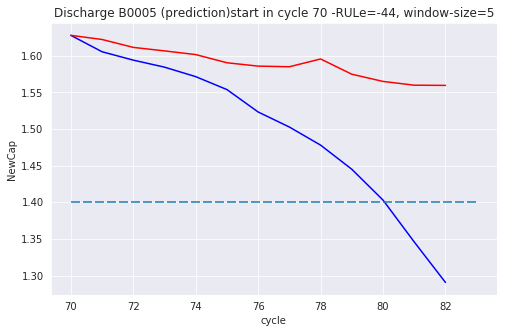

In [171]:

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plot_df = data_train.loc[(data_train['cycle']>=1),['cycle','Capacity']]
plot_per=dataset.loc[(dataset['cycle']>=1),['cycle','Capacity']]
sns.set_style("darkgrid")
plt.figure(figsize=(8, 5))
plt.plot(plot_df['cycle'], plot_df['Capacity'], label="Prediction data", color='blue')
plt.plot(plot_per['cycle'],plot_per['Capacity'],label="Actual data", color='red')
#plt.plot(pred)
#Draw threshold
plt.plot([70.0,83], [1.4, 1.4],dashes=[6, 2])
plt.ylabel('NewCap')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.title('Discharge B0005 (prediction)start in cycle 70 -RULe=-44, window-size=5')

Text(0.5, 1.0, 'Discharge B0005 (prediction)start in cycle 60 -RULe=-49, window-size=5')

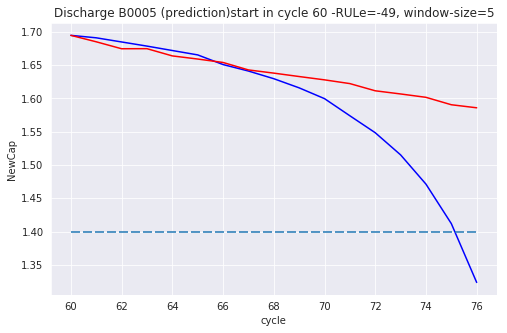

In [184]:

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plot_df = data_train.loc[(data_train['cycle']>=1),['cycle','Capacity']]
plot_per=dataset.loc[(dataset['cycle']>=1),['cycle','Capacity']]
sns.set_style("darkgrid")
plt.figure(figsize=(8, 5))
plt.plot(plot_df['cycle'], plot_df['Capacity'], label="Prediction data", color='blue')
plt.plot(plot_per['cycle'],plot_per['Capacity'],label="Actual data", color='red')
#plt.plot(pred)
#Draw threshold
plt.plot([60.0,76], [1.4, 1.4],dashes=[6, 2])
plt.ylabel('NewCap')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.title('Discharge B0005 (prediction)start in cycle 60 -RULe=-49, window-size=5')

Text(0.5, 1.0, 'Discharge B0005 (prediction)start in cycle 50 -RULe=NANE, window-size=5')

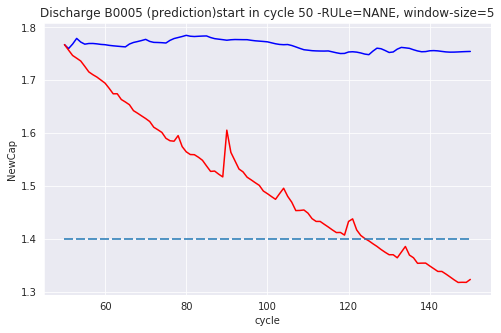

In [218]:

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plot_df = data_train.loc[(data_train['cycle']>=1),['cycle','Capacity']]
plot_per=dataset.loc[(dataset['cycle']>=1),['cycle','Capacity']]
sns.set_style("darkgrid")
plt.figure(figsize=(8, 5))
plt.plot(plot_df['cycle'], plot_df['Capacity'], label="Actual data", color='blue')
plt.plot(plot_per['cycle'],plot_per['Capacity'],label="Prediction data", color='red')
#plt.plot(pred)
#Draw threshold
plt.plot([50.0,150], [1.4, 1.4],dashes=[6, 2])
plt.ylabel('NewCap')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.title('Discharge B0005 (prediction)start in cycle 50 -RULe=NANE, window-size=5')